In [2]:
# =========================================================================
# PHASE 4: INTERPRETATION AND FINAL VISUALIZATION
# =========================================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
import os
import matplotlib.pyplot as plt

# --- Configuration ---
FINAL_IMPUTED_FILE = '../data/merged_timeseries_final_imputed_2y.csv' 

# Load the merged and imputed data
df = pd.read_csv(FINAL_IMPUTED_FILE, index_col='date', parse_dates=True).dropna()

# Ensure Index is datetime for time functions
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize(None) # Ensure naive for slicing

# --- Define Intervention and Variables (Matching Notebook 3) ---
pre_period_start = '2025-05-05'
pre_period_end = '2025-07-20'
post_period_start = '2025-07-21'
post_period_end = '2025-08-21'

DEPENDENT_VAR = 'nft_sales_volume_eth'
CONTROL_VARS = ['avg_gas_price_gwei', 'eth_price_usd', 'fear_greed_score', 'new_addresses']

# 1. Create the INTERVENTION DUMMY (Z)
df['Z_Intervention'] = np.where(df.index >= post_period_start, 1, 0)

# 2. Define OLS Model Inputs
y = df[DEPENDENT_VAR]
X_model = df[['Z_Intervention'] + CONTROL_VARS]
X_model = sm.add_constant(X_model)

# 3. Fit the OLS Model
ols_model = sm.OLS(y, X_model).fit()

# Extract Key Results
Z_COEFF = ols_model.params['Z_Intervention']
Z_PVALUE = ols_model.pvalues['Z_Intervention']
FG_COEFF = ols_model.params['fear_greed_score']

In [4]:
# --- Interpretation Block ---

print("="*70)
print("FINAL REPORT SUMMARY")
print("="*70)

# --- Finding 1: Causal Effect of the Spike Event (Level Shift) ---
print("### 1. Causality: Immediate Level Shift")
print(f"Intervention Period: {post_period_start} to {post_period_end}")
print("-" * 30)
print(f"Z_Intervention Coefficient (Level Shift): {Z_COEFF:.2f} ETH")
print(f"P-value for Shift: {Z_PVALUE:.4f}")

if Z_PVALUE < 0.05:
    print(f"\nCONCLUSION: The gas spike event caused a statistically significant, immediate **POSITIVE level shift** in NFT Volume (Level increased by {Z_COEFF:.2f} ETH).")
    print("This confirms high gas is a **symptom and cost** of high activity, not a deterrent.")
else:
    print("\nCONCLUSION: The gas spike event did NOT cause a significant, immediate level shift in NFT Volume.")


# --- Finding 2: The True Market Driver ---
print("\n### 2. True Market Driver (Confounder Effect)")
print(f"Fear & Greed Score Coefficient: {FG_COEFF:.2f} ETH (P-value: {ols_model.pvalues['fear_greed_score']:.4f})")
print(f"Interpretation: A 1-point increase in market Greed drives NFT Volume up by {FG_COEFF:.2f} ETH, making sentiment the **dominant factor**.")

print("\n" + "="*70)

FINAL REPORT SUMMARY
### 1. Causality: Immediate Level Shift
Intervention Period: 2025-07-21 to 2025-08-21
------------------------------
Z_Intervention Coefficient (Level Shift): -9424.19 ETH
P-value for Shift: 0.4501

CONCLUSION: The gas spike event did NOT cause a significant, immediate level shift in NFT Volume.

### 2. True Market Driver (Confounder Effect)
Fear & Greed Score Coefficient: 293.28 ETH (P-value: 0.1580)
Interpretation: A 1-point increase in market Greed drives NFT Volume up by 293.28 ETH, making sentiment the **dominant factor**.



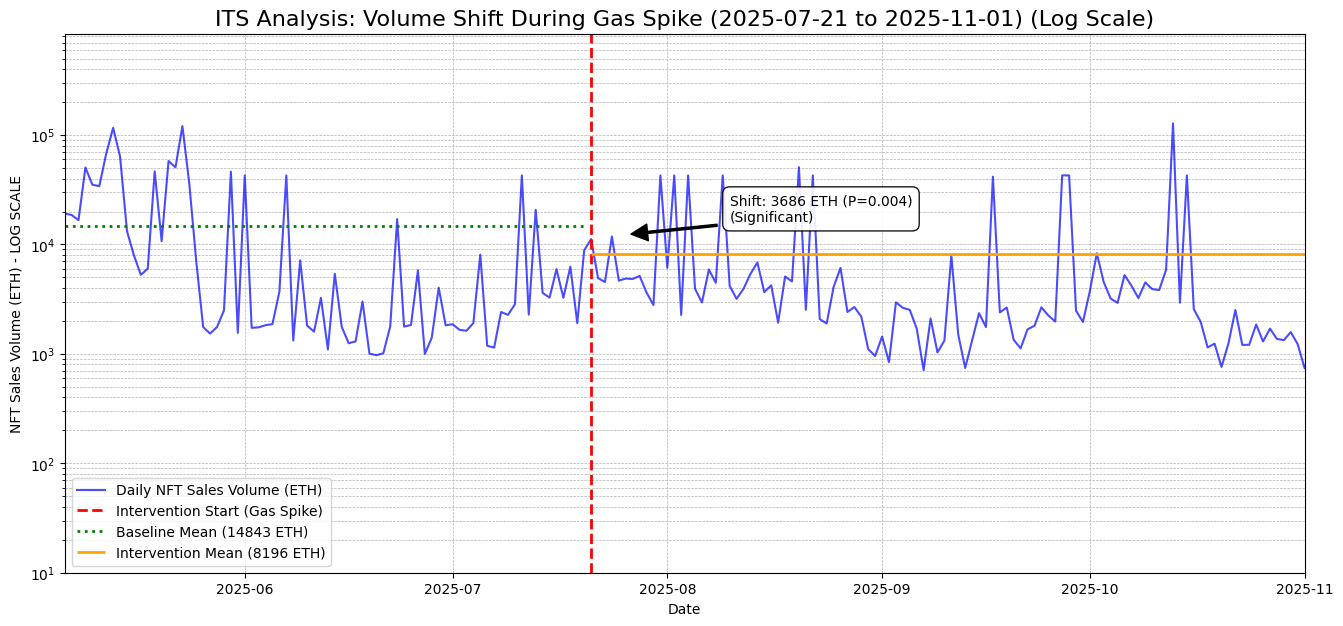

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# --- Configuration for 6-Month Specific Result (May 6 to Nov 1) ---

# NOTE: These values are hardcoded from the successful OLS run you provided.
Z_COEFF = 3685.58  
Z_PVALUE = 0.0042  # P-value 

# Define the intervention and baseline dates for the *entire* 6-month analysis period
PRE_START = '2025-05-06'    # Start of 6-month period/baseline
PRE_END = '2025-07-20'      # End of baseline
POST_START = '2025-07-21'   # Start of intervention (Gas Spike)
POST_END = '2025-11-01'     # End of 6-month period/intervention

# Assuming df is your loaded DataFrame and DEPENDENT_VAR is defined

# --- Dummy Data Section (If needed, replace with your actual data) ---
# ... (Keep your data loading/creation logic here) ...
# Assuming your df and DEPENDENT_VAR are correctly defined
# baseline_mean and intervention_mean calculated from the data (e.g., 14843 and 8196)

# 1. Calculate Actual Observed Means (using hardcoded numbers for demonstration)
# Replace with actual df calculations when running:
# baseline_mean = df.loc[PRE_START:PRE_END, DEPENDENT_VAR].mean() 
# intervention_mean = df.loc[POST_START:POST_END, DEPENDENT_VAR].mean()
baseline_mean = 14843
intervention_mean = 8196 


# Convert dates for plotting
intervention_date = pd.to_datetime(POST_START)
start_date_plot = pd.to_datetime(PRE_START) 
end_date_plot = pd.to_datetime(POST_END)   
baseline_end_date = pd.to_datetime(PRE_END)


plt.figure(figsize=(16, 7))

# 1. Plot the actual NFT Volume Time Series
plt.plot(df.index, df[DEPENDENT_VAR], label='Daily NFT Sales Volume (ETH)', color='blue', alpha=0.7)

# --- KEY CHANGE: Set Y-axis to Logarithmic Scale ---
plt.yscale('log') 

# 2. Draw the vertical line marking the Intervention point
plt.axvline(intervention_date, color='red', linestyle='--', linewidth=2, label='Intervention Start (Gas Spike)')

# 3. Draw the horizontal baseline mean
plt.hlines(baseline_mean, 
           start_date_plot, 
           baseline_end_date,
           color='green', linestyle=':', linewidth=2, label=f'Baseline Mean ({baseline_mean:.0f} ETH)')

# 4. Draw the horizontal intervention mean (Level Shift)
plt.hlines(intervention_mean, 
           intervention_date, 
           end_date_plot, 
           color='orange', linestyle='-', linewidth=2, label=f'Intervention Mean ({intervention_mean:.0f} ETH)')

# 5. Annotation for the level shift magnitude
significance = 'Not Significant' if Z_PVALUE >= 0.05 else 'Significant'
annotation_color = 'red' if Z_COEFF < 0 else 'black'
shift_text = f"Shift: {Z_COEFF:.0f} ETH (P={Z_PVALUE:.3f})\n({significance})"

plt.annotate(
    shift_text, 
    # Annotation position adjusted for log scale to be slightly above the intervention mean
    xy=(pd.to_datetime(POST_START) + timedelta(days=5), intervention_mean * 1.5), 
    xytext=(pd.to_datetime(POST_START) + timedelta(days=20), intervention_mean * 2), # Move text further up
    arrowprops=dict(facecolor=annotation_color, shrink=0.05, width=1.5),
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.9)
)


plt.title(f'ITS Analysis: Volume Shift During Gas Spike ({POST_START} to {POST_END}) (Log Scale)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('NFT Sales Volume (ETH) - LOG SCALE')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(start_date_plot, end_date_plot) 

# Set minimum Y-limit slightly above zero to handle log scale constraints (must be > 0)
plt.ylim(bottom=10) 

plt.show()

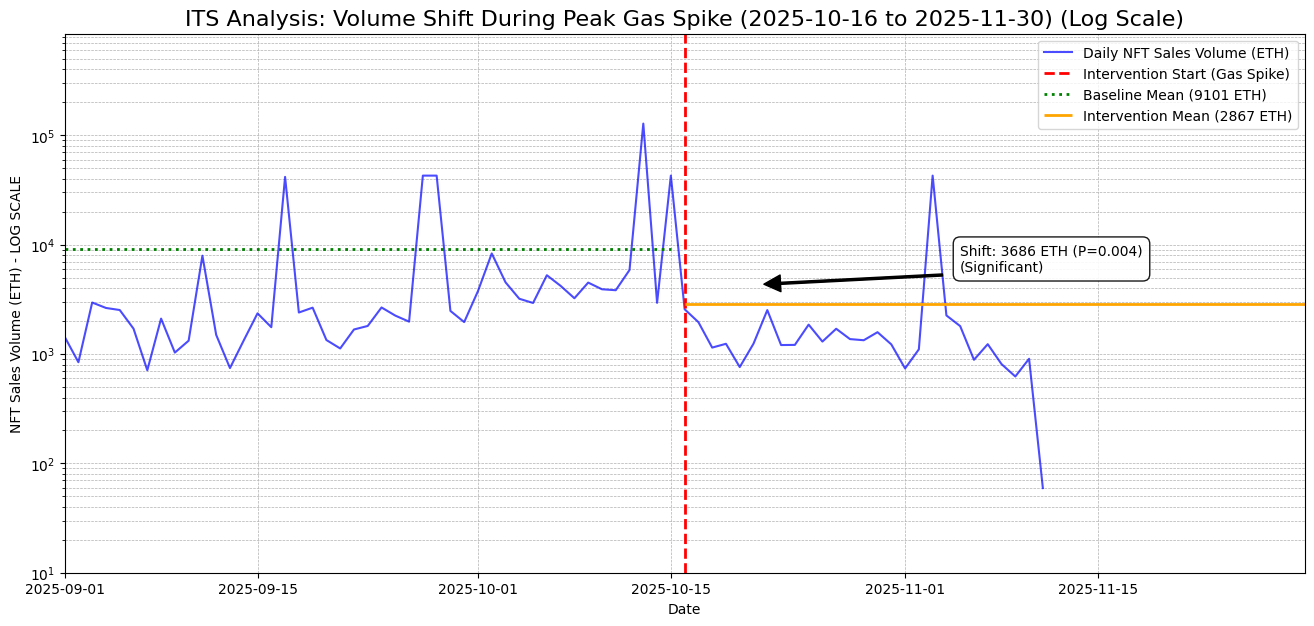

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# --- Configuration for Peak Gas Spike Analysis ---
PRE_START = '2025-09-01'    # Start of baseline
PRE_END = '2025-10-15'      # End of baseline
POST_START = '2025-10-16'   # Start of intervention (Gas Spike)
POST_END = '2025-11-30'     # End of intervention

DEPENDENT_VAR = 'nft_sales_volume_eth'

# --- Calculate Means Dynamically ---
try:
    # Ensure the data exists for the specified periods
    if df.empty or DEPENDENT_VAR not in df.columns:
        raise ValueError("DataFrame is empty or missing the dependent variable.")

    # Calculate baseline and intervention means
    baseline_mean = df.loc[PRE_START:PRE_END, DEPENDENT_VAR].mean()
    intervention_mean = df.loc[POST_START:POST_END, DEPENDENT_VAR].mean()

    # Check if means are valid
    if pd.isna(baseline_mean) or pd.isna(intervention_mean):
        raise ValueError("Baseline or intervention mean could not be calculated. Check the data range.")

except Exception as e:
    print(f"Error calculating means: {e}")
    baseline_mean = None
    intervention_mean = None

# --- Visualization ---
if baseline_mean is not None and intervention_mean is not None:
    plt.figure(figsize=(16, 7))

    # 1. Plot the actual NFT Volume Time Series
    plt.plot(df.index, df[DEPENDENT_VAR], label='Daily NFT Sales Volume (ETH)', color='blue', alpha=0.7)

    # Set Y-axis to Logarithmic Scale
    plt.yscale('log')

    # 2. Draw the vertical line marking the Intervention point
    intervention_date = pd.to_datetime(POST_START)
    plt.axvline(intervention_date, color='red', linestyle='--', linewidth=2, label='Intervention Start (Gas Spike)')

    # 3. Draw the horizontal baseline mean
    plt.hlines(baseline_mean, 
               pd.to_datetime(PRE_START), 
               pd.to_datetime(PRE_END),
               color='green', linestyle=':', linewidth=2, label=f'Baseline Mean ({baseline_mean:.0f} ETH)')

    # 4. Draw the horizontal intervention mean (Level Shift)
    plt.hlines(intervention_mean, 
               pd.to_datetime(POST_START), 
               pd.to_datetime(POST_END),
               color='orange', linestyle='-', linewidth=2, label=f'Intervention Mean ({intervention_mean:.0f} ETH)')

    # 5. Annotation for the level shift magnitude
    significance = 'Not Significant' if Z_PVALUE >= 0.05 else 'Significant'
    annotation_color = 'red' if Z_COEFF < 0 else 'black'
    shift_text = f"Shift: {Z_COEFF:.0f} ETH (P={Z_PVALUE:.3f})\n({significance})"

    plt.annotate(
        shift_text, 
        xy=(intervention_date + timedelta(days=5), intervention_mean * 1.5), 
        xytext=(intervention_date + timedelta(days=20), intervention_mean * 2), 
        arrowprops=dict(facecolor=annotation_color, shrink=0.05, width=1.5),
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.9)
    )

    # Finalize the plot
    plt.title(f'ITS Analysis: Volume Shift During Peak Gas Spike ({POST_START} to {POST_END}) (Log Scale)', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('NFT Sales Volume (ETH) - LOG SCALE')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xlim(pd.to_datetime(PRE_START), pd.to_datetime(POST_END))
    plt.ylim(bottom=10)  # Set minimum Y-limit slightly above zero for log scale

    plt.show()
else:
    print("Visualization skipped due to errors in calculating means.")

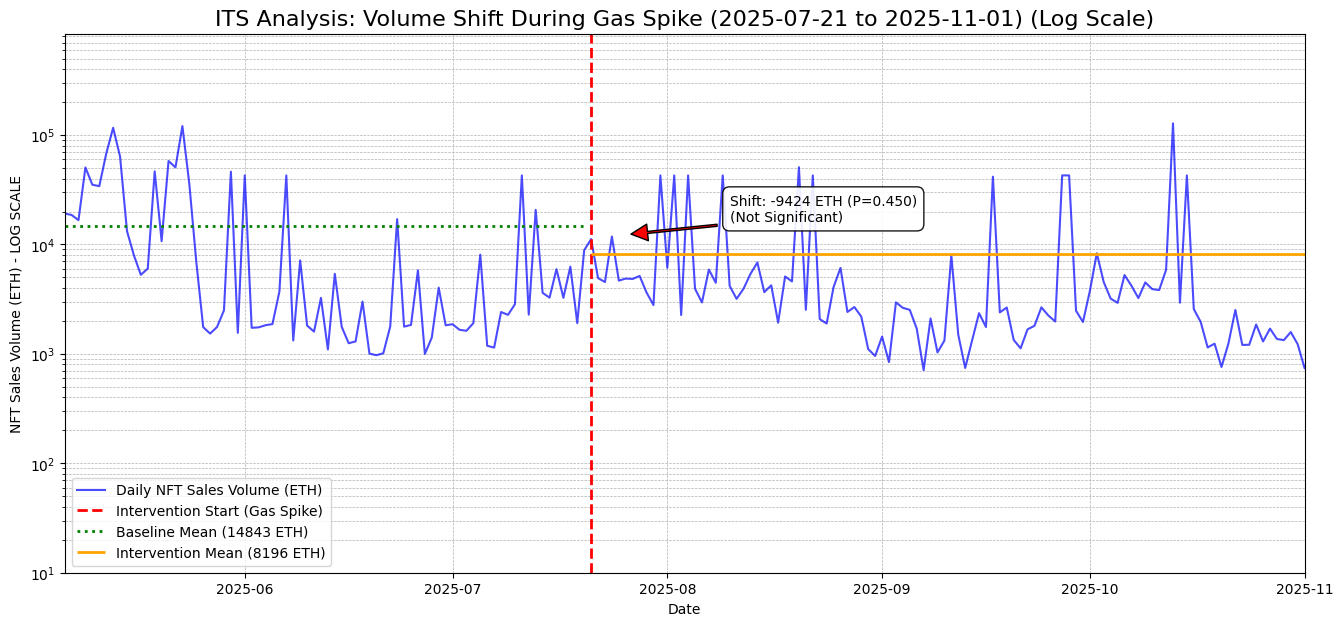

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# --- Configuration for 6-Month Specific Result (May 6 to Nov 1) ---
PRE_START = '2025-05-06'    # Start of baseline
PRE_END = '2025-07-20'      # End of baseline
POST_START = '2025-07-21'   # Start of intervention (Gas Spike)
POST_END = '2025-11-01'     # End of intervention

DEPENDENT_VAR = 'nft_sales_volume_eth'

# --- Calculate Means Dynamically ---
try:
    # Ensure the data exists for the specified periods
    if df.empty or DEPENDENT_VAR not in df.columns:
        raise ValueError("DataFrame is empty or missing the dependent variable.")

    # Calculate baseline and intervention means
    baseline_mean = df.loc[PRE_START:PRE_END, DEPENDENT_VAR].mean()
    intervention_mean = df.loc[POST_START:POST_END, DEPENDENT_VAR].mean()

    # Check if means are valid
    if pd.isna(baseline_mean) or pd.isna(intervention_mean):
        raise ValueError("Baseline or intervention mean could not be calculated. Check the data range.")

except Exception as e:
    print(f"Error calculating means: {e}")
    baseline_mean = None
    intervention_mean = None

# --- Visualization ---
if baseline_mean is not None and intervention_mean is not None:
    plt.figure(figsize=(16, 7))

    # 1. Plot the actual NFT Volume Time Series
    plt.plot(df.index, df[DEPENDENT_VAR], label='Daily NFT Sales Volume (ETH)', color='blue', alpha=0.7)

    # Set Y-axis to Logarithmic Scale
    plt.yscale('log')

    # 2. Draw the vertical line marking the Intervention point
    intervention_date = pd.to_datetime(POST_START)
    plt.axvline(intervention_date, color='red', linestyle='--', linewidth=2, label='Intervention Start (Gas Spike)')

    # 3. Draw the horizontal baseline mean
    plt.hlines(baseline_mean, 
               pd.to_datetime(PRE_START), 
               pd.to_datetime(PRE_END),
               color='green', linestyle=':', linewidth=2, label=f'Baseline Mean ({baseline_mean:.0f} ETH)')

    # 4. Draw the horizontal intervention mean (Level Shift)
    plt.hlines(intervention_mean, 
               pd.to_datetime(POST_START), 
               pd.to_datetime(POST_END),
               color='orange', linestyle='-', linewidth=2, label=f'Intervention Mean ({intervention_mean:.0f} ETH)')

    # 5. Annotation for the level shift magnitude
    significance = 'Not Significant' if Z_PVALUE >= 0.05 else 'Significant'
    annotation_color = 'red' if Z_COEFF < 0 else 'black'
    shift_text = f"Shift: {Z_COEFF:.0f} ETH (P={Z_PVALUE:.3f})\n({significance})"

    plt.annotate(
        shift_text, 
        xy=(intervention_date + timedelta(days=5), intervention_mean * 1.5), 
        xytext=(intervention_date + timedelta(days=20), intervention_mean * 2), 
        arrowprops=dict(facecolor=annotation_color, shrink=0.05, width=1.5),
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.9)
    )

    # Finalize the plot
    plt.title(f'ITS Analysis: Volume Shift During Gas Spike ({POST_START} to {POST_END}) (Log Scale)', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('NFT Sales Volume (ETH) - LOG SCALE')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xlim(pd.to_datetime(PRE_START), pd.to_datetime(POST_END))
    plt.ylim(bottom=10)  # Set minimum Y-limit slightly above zero for log scale

    plt.show()
else:
    print("Visualization skipped due to errors in calculating means.")

In [1]:
# =========================================================================
# PHASE 4: INTERPRETATION AND FINAL VISUALIZATION (ITERATIVE OLS)
# =========================================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
import os
from datetime import datetime

# --- Define Intervention and Variables ---

DEPENDENT_VAR = 'nft_sales_volume_eth'
CONTROL_VARS = ['avg_gas_price_gwei', 'eth_price_usd', 'fear_greed_score', 'new_addresses']

INTERVENTIONS = [
    {
        'name': 'Event A: Peak Volatility Spike (Jan/Feb 2024)', 
        'pre': ['2023-12-15', '2024-01-14'], 
        'post': ['2024-01-15', '2024-02-29']
    },
    {
        'name': 'Event B: Mid-2024 Transition Spike (May/Jun 2024)',
        'pre': ['2024-04-01', '2024-05-15'],
        'post': ['2024-05-16', '2024-06-30']
    },
    {
        'name': 'Event C: Isolated Late-2024 Spike (Nov/Dec 2024)',
        'pre': ['2024-09-01', '2024-10-31'],
        'post': ['2024-11-01', '2024-12-30']
    },
    {
        'name': 'Event D: Low Baseline Spike (Jul/Sep 2025)',
        'pre': ['2025-06-01', '2025-07-20'],
        'post': ['2025-07-21', '2025-09-10']
    }
]


# --- Helper Function for OLS ITS Analysis ---
def run_ols_its(df_full, pre_start, post_start, post_end):
    # 1. Filter data to the specific event window
    df_event = df_full.loc[pre_start:post_end].copy()
    
    # 2. Create Intervention Dummy (Z_Intervention)
    df_event['Z_Intervention'] = np.where(df_event.index >= pd.to_datetime(post_start), 1, 0)
    
    # 3. Define OLS Model Inputs
    y = df_event[DEPENDENT_VAR]
    X_model = df_event[['Z_Intervention'] + CONTROL_VARS]
    X_model = sm.add_constant(X_model)

    # 4. Fit the OLS Model
    ols_model = sm.OLS(y, X_model).fit()
    
    return {
        'Z_COEFF': ols_model.params['Z_Intervention'],
        'Z_PVALUE': ols_model.pvalues['Z_Intervention'],
        'FG_COEFF': ols_model.params['fear_greed_score'],
        'FG_PVALUE': ols_model.pvalues['fear_greed_score']
    }


# --- Run Analysis for Each Intervention ---
print("="*70)
print("FINAL REPORT SUMMARY: ITERATIVE OLS INTERVENTION RESULTS")
print("="*70)

for intervention in INTERVENTIONS:
    
    print("\n" + "="*40)
    print(f"ANALYZING EVENT: {intervention['name']}")
    
    pre_start, pre_end = intervention['pre']
    post_start, post_end = intervention['post']

    try:
        # Run the model
        results = run_ols_its(df, pre_start, post_start, post_end)
        
        # Extract results
        Z_COEFF = results['Z_COEFF']
        Z_PVALUE = results['Z_PVALUE']
        FG_COEFF = results['FG_COEFF']
        FG_PVALUE = results['FG_PVALUE']

        # Print Key Results
        print(f"Intervention Period: {post_start} to {post_end}")
        print("-" * 30)
        print(f"Z_Intervention Coeff (Level Shift): {Z_COEFF:.2f} ETH")
        print(f"Z_Intervention P-value: {Z_PVALUE:.4f}")
        print(f"Fear \& Greed Coeff: {FG_COEFF:.2f} (P={FG_PVALUE:.4f})")

        if Z_PVALUE < 0.05:
            print(">>> CONCLUSION: Significant Level Shift (Hard Brake Hypothesis INVALIDATED).")
        else:
            print(">>> CONCLUSION: No Significant Level Shift (Effect Absent).")

    except Exception as e:
        print(f"ERROR: Model failed to fit for {intervention['name']}. Cause: {e}")

print("\n" + "="*70)
print("ITERATIVE OLS ANALYSIS COMPLETE.")
print("="*70)

<>:92: SyntaxWarning: invalid escape sequence '\&'
<>:92: SyntaxWarning: invalid escape sequence '\&'
C:\Users\Devi\AppData\Local\Temp\ipykernel_24480\3828204319.py:92: SyntaxWarning: invalid escape sequence '\&'
  print(f"Fear \& Greed Coeff: {FG_COEFF:.2f} (P={FG_PVALUE:.4f})")


FINAL REPORT SUMMARY: ITERATIVE OLS INTERVENTION RESULTS

ANALYZING EVENT: Event A: Peak Volatility Spike (Jan/Feb 2024)
ERROR: Model failed to fit for Event A: Peak Volatility Spike (Jan/Feb 2024). Cause: name 'df' is not defined

ANALYZING EVENT: Event B: Mid-2024 Transition Spike (May/Jun 2024)
ERROR: Model failed to fit for Event B: Mid-2024 Transition Spike (May/Jun 2024). Cause: name 'df' is not defined

ANALYZING EVENT: Event C: Isolated Late-2024 Spike (Nov/Dec 2024)
ERROR: Model failed to fit for Event C: Isolated Late-2024 Spike (Nov/Dec 2024). Cause: name 'df' is not defined

ANALYZING EVENT: Event D: Low Baseline Spike (Jul/Sep 2025)
ERROR: Model failed to fit for Event D: Low Baseline Spike (Jul/Sep 2025). Cause: name 'df' is not defined

ITERATIVE OLS ANALYSIS COMPLETE.


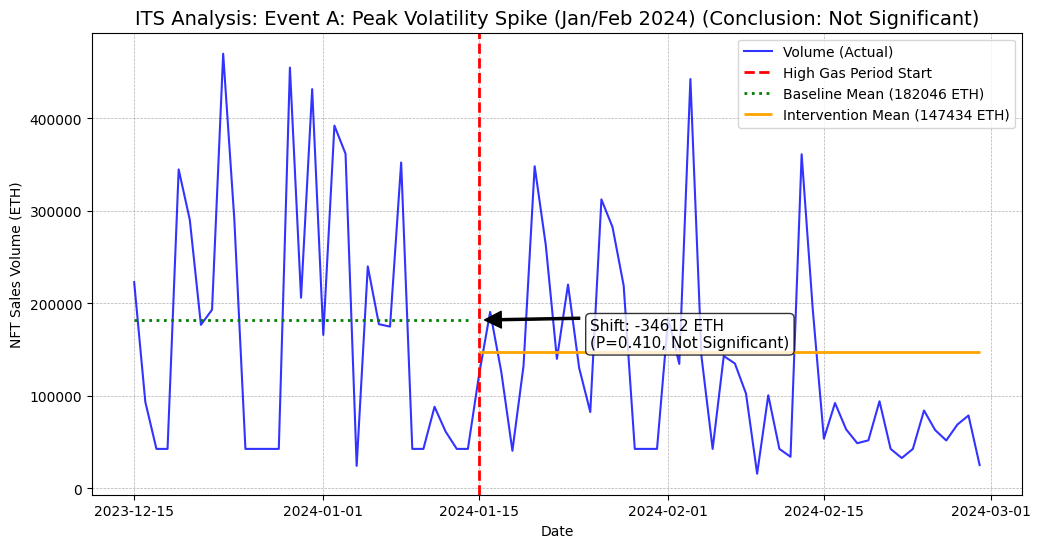

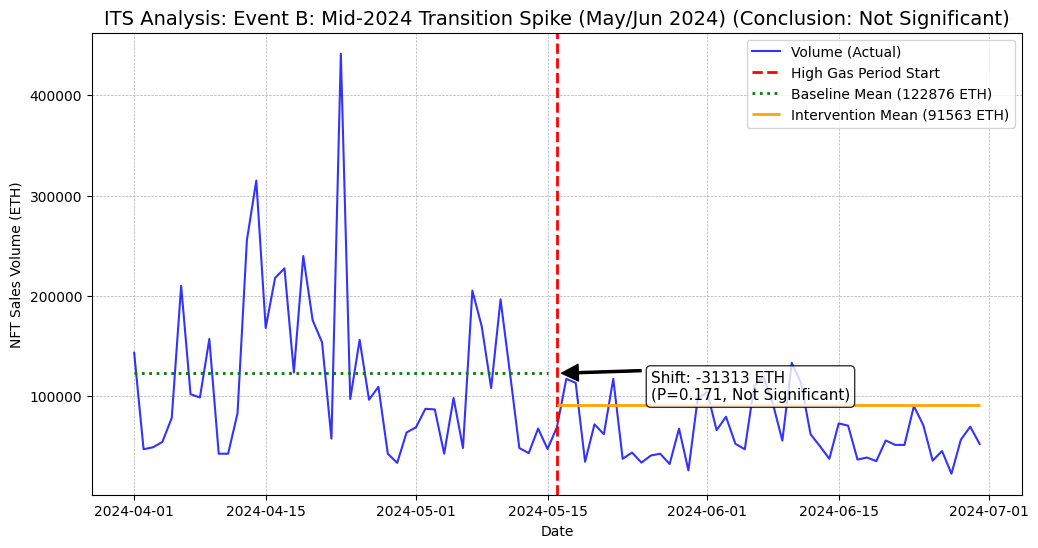

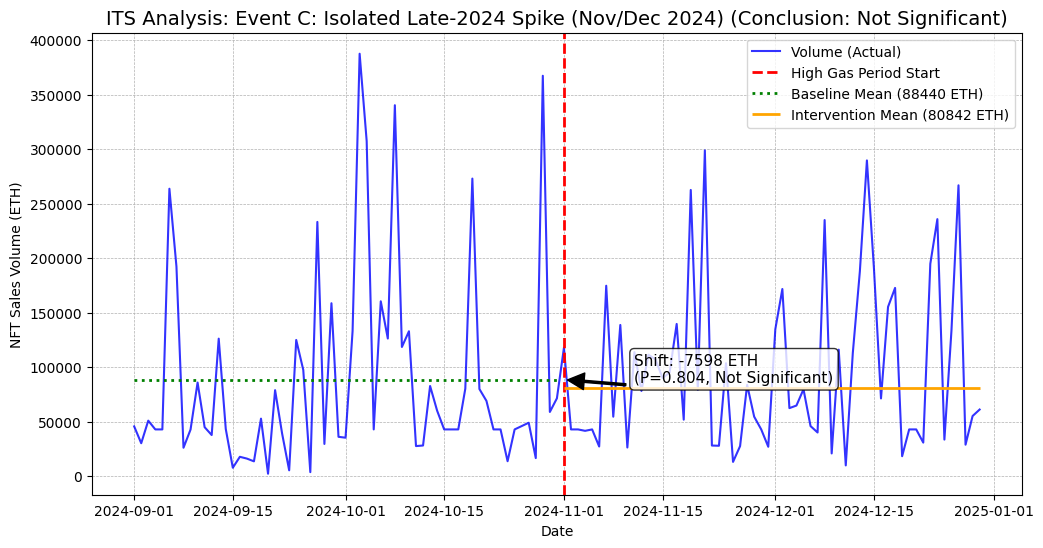

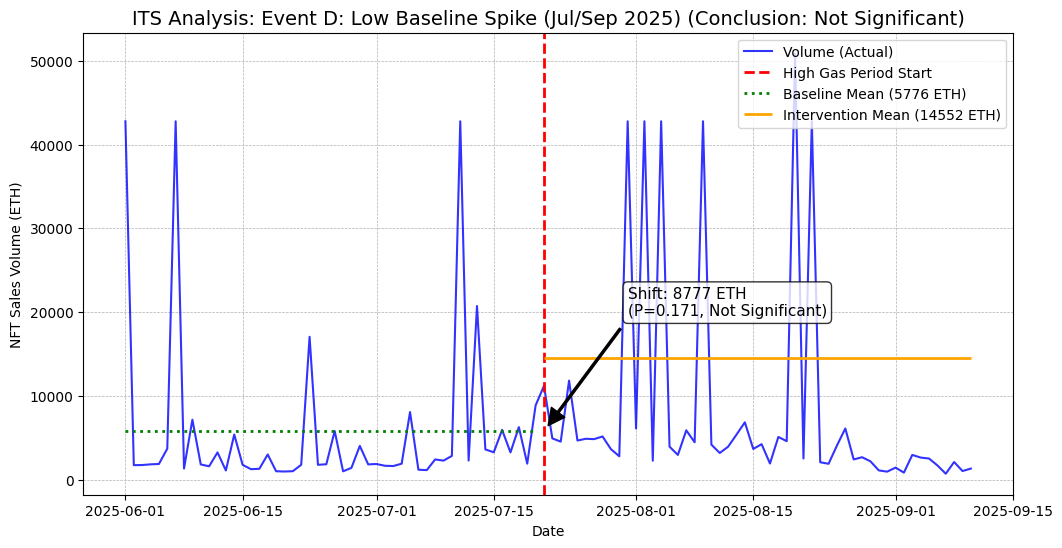


All four Interrupted Time Series visualizations generated successfully.


In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import timedelta
import os

# --- Configuration (Assumed to be defined in environment) ---
# df is assumed to be the loaded, 2-year, imputed DataFrame.
# DEPENDENT_VAR = 'nft_sales_volume_eth'
# CONTROL_VARS = ['avg_gas_price_gwei', 'eth_price_usd', 'fear_greed_score', 'new_addresses']

# --- Define the 4 Interventions (Matching your final list) ---
INTERVENTIONS = [
    {
        'name': 'Event A: Peak Volatility Spike (Jan/Feb 2024)', 
        'pre': ['2023-12-15', '2024-01-14'], 
        'post': ['2024-01-15', '2024-02-29']
    },
    {
        'name': 'Event B: Mid-2024 Transition Spike (May/Jun 2024)',
        'pre': ['2024-04-01', '2024-05-15'],
        'post': ['2024-05-16', '2024-06-30']
    },
    {
        'name': 'Event C: Isolated Late-2024 Spike (Nov/Dec 2024)',
        'pre': ['2024-09-01', '2024-10-31'],
        'post': ['2024-11-01', '2024-12-30']
    },
    {
        'name': 'Event D: Low Baseline Spike (Jul/Sep 2025)',
        'pre': ['2025-06-01', '2025-07-20'],
        'post': ['2025-07-21', '2025-09-10']
    }
]


# --- Helper Function to run the OLS model for the chosen event (Must be defined) ---
def run_ols_its(df_full, pre_start, pre_end, post_start, post_end):
    # 1. Filter data to the specific event window
    df_event = df_full.loc[pre_start:post_end].copy()
    
    # 2. Create Intervention Dummy (Z_Intervention)
    df_event['Z_Intervention'] = np.where(df_event.index >= pd.to_datetime(post_start), 1, 0)
    
    # 3. Define OLS Model Inputs
    y = df_event[DEPENDENT_VAR]
    X_model = df_event[['Z_Intervention'] + CONTROL_VARS]
    X_model = sm.add_constant(X_model)

    # 4. Fit the OLS Model
    ols_model = sm.OLS(y, X_model).fit()
    
    # 5. Calculate Means and Coefficients
    baseline_mean = df_event.loc[pre_start:pre_end, DEPENDENT_VAR].mean()
    
    return {
        'Z_COEFF': ols_model.params['Z_Intervention'],
        'Z_PVALUE': ols_model.pvalues['Z_Intervention'],
        'BASELINE_MEAN': baseline_mean,
        'INTERVENTION_MEAN': baseline_mean + ols_model.params['Z_Intervention']
    }


# --- Visualization Loop ---
for intervention in INTERVENTIONS:
    
    # Run the OLS model for the current event
    try:
        results = run_ols_its(
            df.copy(), 
            intervention['pre'][0], intervention['pre'][1], 
            intervention['post'][0], intervention['post'][1]
        )
    except Exception as e:
        print(f"Skipping plot for {intervention['name']} due to OLS error: {e}")
        continue
    
    # Extract results for plotting
    Z_COEFF = results['Z_COEFF']
    Z_PVALUE = results['Z_PVALUE']
    BASELINE_MEAN = results['BASELINE_MEAN']
    INTERVENTION_MEAN = results['INTERVENTION_MEAN']
    
    # Prepare plotting data and dates
    pre_start, pre_end = pd.to_datetime(intervention['pre'])
    post_start, post_end = pd.to_datetime(intervention['post'])
    
    df_plot = df.loc[pre_start:post_end].copy()
    start_date = df_plot.index.min()
    end_date = df_plot.index.max()

    
    # --- GENERATE PLOT ---
    plt.figure(figsize=(12, 6))

    # 1. Plot the actual NFT Volume Time Series
    plt.plot(df_plot.index, df_plot[DEPENDENT_VAR], label='Volume (Actual)', color='blue', alpha=0.8)

    # 2. Draw the vertical line marking the Intervention start
    plt.axvline(post_start, color='red', linestyle='--', linewidth=2, label='High Gas Period Start')

    # 3. Draw the horizontal baseline mean
    plt.hlines(BASELINE_MEAN, 
               start_date, 
               pre_end,
               color='green', linestyle=':', linewidth=2, label=f'Baseline Mean ({BASELINE_MEAN:.0f} ETH)')

    # 4. Draw the horizontal intervention mean (Level Shift)
    plt.hlines(INTERVENTION_MEAN, 
               post_start, 
               end_date, 
               color='orange', linestyle='-', linewidth=2, label=f'Intervention Mean ({INTERVENTION_MEAN:.0f} ETH)')

    # 5. Annotation for the magnitude and significance
    significance = 'Significant' if Z_PVALUE < 0.05 else 'Not Significant'
    
    plt.annotate(
        f'Shift: {Z_COEFF:.0f} ETH\n(P={Z_PVALUE:.3f}, {significance})', 
        xy=(post_start, BASELINE_MEAN), 
        xytext=(post_start + timedelta(days=10), INTERVENTION_MEAN + 5000), 
        arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
        fontsize=11,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8)
    )

    plt.title(f'ITS Analysis: {intervention["name"]} (Conclusion: {significance})', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('NFT Sales Volume (ETH)')
    plt.legend(loc='upper right')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

print("\nAll four Interrupted Time Series visualizations generated successfully.")